In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

In [112]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [113]:
df_insurance = pd.read_csv("/content/drive/MyDrive/ML project/train_Insurance.csv", sep=",") # 5012 rows × 13 columns
# Display the first 5 individuals of df_insurance
df_insurance #.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Geo_Code,Claim
0,H13501,2012,1.0,1,N,V,V,U,1240.0,Wood-framed,without,75117,non
1,H14962,2012,1.0,0,N,V,V,U,900.0,Non-combustible,without,62916,non
2,H17755,2013,1.0,1,V,N,O,R,4984.0,Non-combustible,4,31149,oui
3,H13369,2016,0.5,0,N,V,V,U,600.0,Wood-framed,without,6012,oui
4,H12988,2012,1.0,0,N,V,V,U,900.0,Non-combustible,without,57631,non
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5007,H13682,2013,1.0,0,N,V,V,U,550.0,Ordinary,without,33063,oui
5008,H18342,2012,0.5,0,V,N,O,R,1000.0,Fire-resistive,4,13004,non
5009,H16892,2015,1.0,1,V,N,O,R,480.0,Ordinary,3,94059,non
5010,H18805,2012,0.5,0,V,N,O,R,536.0,Fire-resistive,4,74243,non


# Data preprocessing

In [114]:
# Display the data types of each column in df_insurance
df_insurance.dtypes

Customer Id            object
YearOfObservation       int64
Insured_Period        float64
Residential             int64
Building_Painted       object
Building_Fenced        object
Garden                 object
Settlement             object
Building Dimension    float64
Building_Type          object
NumberOfWindows        object
Geo_Code               object
Claim                  object
dtype: object

In [115]:
# Display concise summary of df_insurance
# This includes the index dtype and column dtypes, non-null values, and memory usage
df_insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5012 entries, 0 to 5011
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         5012 non-null   object 
 1   YearOfObservation   5012 non-null   int64  
 2   Insured_Period      5012 non-null   float64
 3   Residential         5012 non-null   int64  
 4   Building_Painted    5012 non-null   object 
 5   Building_Fenced     5012 non-null   object 
 6   Garden              5008 non-null   object 
 7   Settlement          5012 non-null   object 
 8   Building Dimension  4935 non-null   float64
 9   Building_Type       5012 non-null   object 
 10  NumberOfWindows     5012 non-null   object 
 11  Geo_Code            4939 non-null   object 
 12  Claim               5012 non-null   object 
dtypes: float64(2), int64(2), object(9)
memory usage: 509.2+ KB


In [116]:
# Generate descriptive statistics of the DataFrame, including all columns
# include="all" == it will also include non-numeric data types
df_insurance.describe(include="all")

# Customer Id: Unique attribute
# Geo_code: 1115 unique values
# Hence, they can be eliminated
# Building Dimension: Wide range of data..

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Geo_Code,Claim
count,5012,5012.000000,5012.000000,5012.000000,5012,5012,5008,5012,4935.000000,5012,5012,4939,5012
unique,5012,NaN,NaN,NaN,2,2,2,2,NaN,4,11,1115,2
top,H13501,NaN,NaN,NaN,V,N,O,R,NaN,Non-combustible,without,6088,non
freq,1,NaN,NaN,NaN,3763,2535,2532,2537,NaN,2310,2476,102,3886
mean,NaN,2013.660215,0.869713,0.301077,NaN,NaN,NaN,NaN,1876.898683,NaN,NaN,NaN,NaN
std,NaN,1.383134,0.219496,0.458772,NaN,NaN,NaN,NaN,2267.277397,NaN,NaN,NaN,NaN
min,NaN,2012.000000,0.500000,0.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
25%,NaN,2012.000000,0.500000,0.000000,NaN,NaN,NaN,NaN,520.000000,NaN,NaN,NaN,NaN
50%,NaN,2013.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,1067.000000,NaN,NaN,NaN,NaN
75%,NaN,2015.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,2280.000000,NaN,NaN,NaN,NaN


In [117]:
# count missing values in each column
df_insurance.isna().sum()

Customer Id            0
YearOfObservation      0
Insured_Period         0
Residential            0
Building_Painted       0
Building_Fenced        0
Garden                 4
Settlement             0
Building Dimension    77
Building_Type          0
NumberOfWindows        0
Geo_Code              73
Claim                  0
dtype: int64

In [118]:
# count all missing values
df_insurance.isnull().sum().sum()

154

<Axes: >

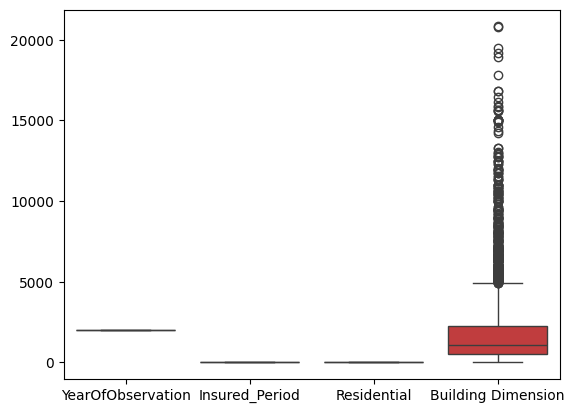

In [119]:
# Boxplot for outlier detection
sns.boxplot(data = df_insurance)

In [120]:
# Remove unique identifier
# At this stage, we will retain Geo_code for reasons
df_insurance.drop(["Customer Id"], axis=1, inplace=True)

In [121]:
# Check for duplicate rows
print(df_insurance[df_insurance.duplicated()].shape[0])
df_insurance[df_insurance.duplicated()]

42


,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Geo_Code,Claim
443,2012,1.0,1,V,N,O,R,999.0,Non-combustible,3,66130,non
584,2013,1.0,0,V,V,V,U,NaN,Non-combustible,without,NaN,non
1601,2012,1.0,0,V,V,V,U,NaN,Non-combustible,without,NaN,non
1663,2014,1.0,0,V,V,V,U,NaN,Non-combustible,without,NaN,non
1685,2014,1.0,0,V,V,V,U,NaN,Fire-resistive,without,NaN,non
1758,2013,1.0,0,V,V,V,U,NaN,Non-combustible,without,NaN,non
1828,2013,0.5,1,V,V,V,U,NaN,Non-combustible,without,NaN,non
1987,2013,0.5,1,V,V,V,U,NaN,Non-combustible,without,NaN,non
2014,2012,1.0,0,V,N,O,R,400.0,Wood-framed,4,6069,non
2116,2012,1.0,0,N,V,V,U,250.0,Non-combustible,without,64122,non


In [122]:
# Remove duplicate rows from the DataFrame
df_insurance.drop_duplicates(inplace=True)
df_insurance.reset_index(drop=True, inplace = True)

In [123]:
df_insurance

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Geo_Code,Claim
0,2012,1.0,1,N,V,V,U,1240.0,Wood-framed,without,75117,non
1,2012,1.0,0,N,V,V,U,900.0,Non-combustible,without,62916,non
2,2013,1.0,1,V,N,O,R,4984.0,Non-combustible,4,31149,oui
3,2016,0.5,0,N,V,V,U,600.0,Wood-framed,without,6012,oui
4,2012,1.0,0,N,V,V,U,900.0,Non-combustible,without,57631,non
...,...,...,...,...,...,...,...,...,...,...,...,...
4965,2013,1.0,0,N,V,V,U,550.0,Ordinary,without,33063,oui
4966,2012,0.5,0,V,N,O,R,1000.0,Fire-resistive,4,13004,non
4967,2015,1.0,1,V,N,O,R,480.0,Ordinary,3,94059,non
4968,2012,0.5,0,V,N,O,R,536.0,Fire-resistive,4,74243,non


In [124]:
l_discret = list(df_insurance.select_dtypes(include="object"))
l_continu = list(set(df_insurance) - set(l_discret))

print(l_discret); print(l_continu)

['Building_Painted', 'Building_Fenced', 'Garden', 'Settlement', 'Building_Type', 'NumberOfWindows', 'Geo_Code', 'Claim']
['YearOfObservation', 'Insured_Period', 'Residential', 'Building Dimension']


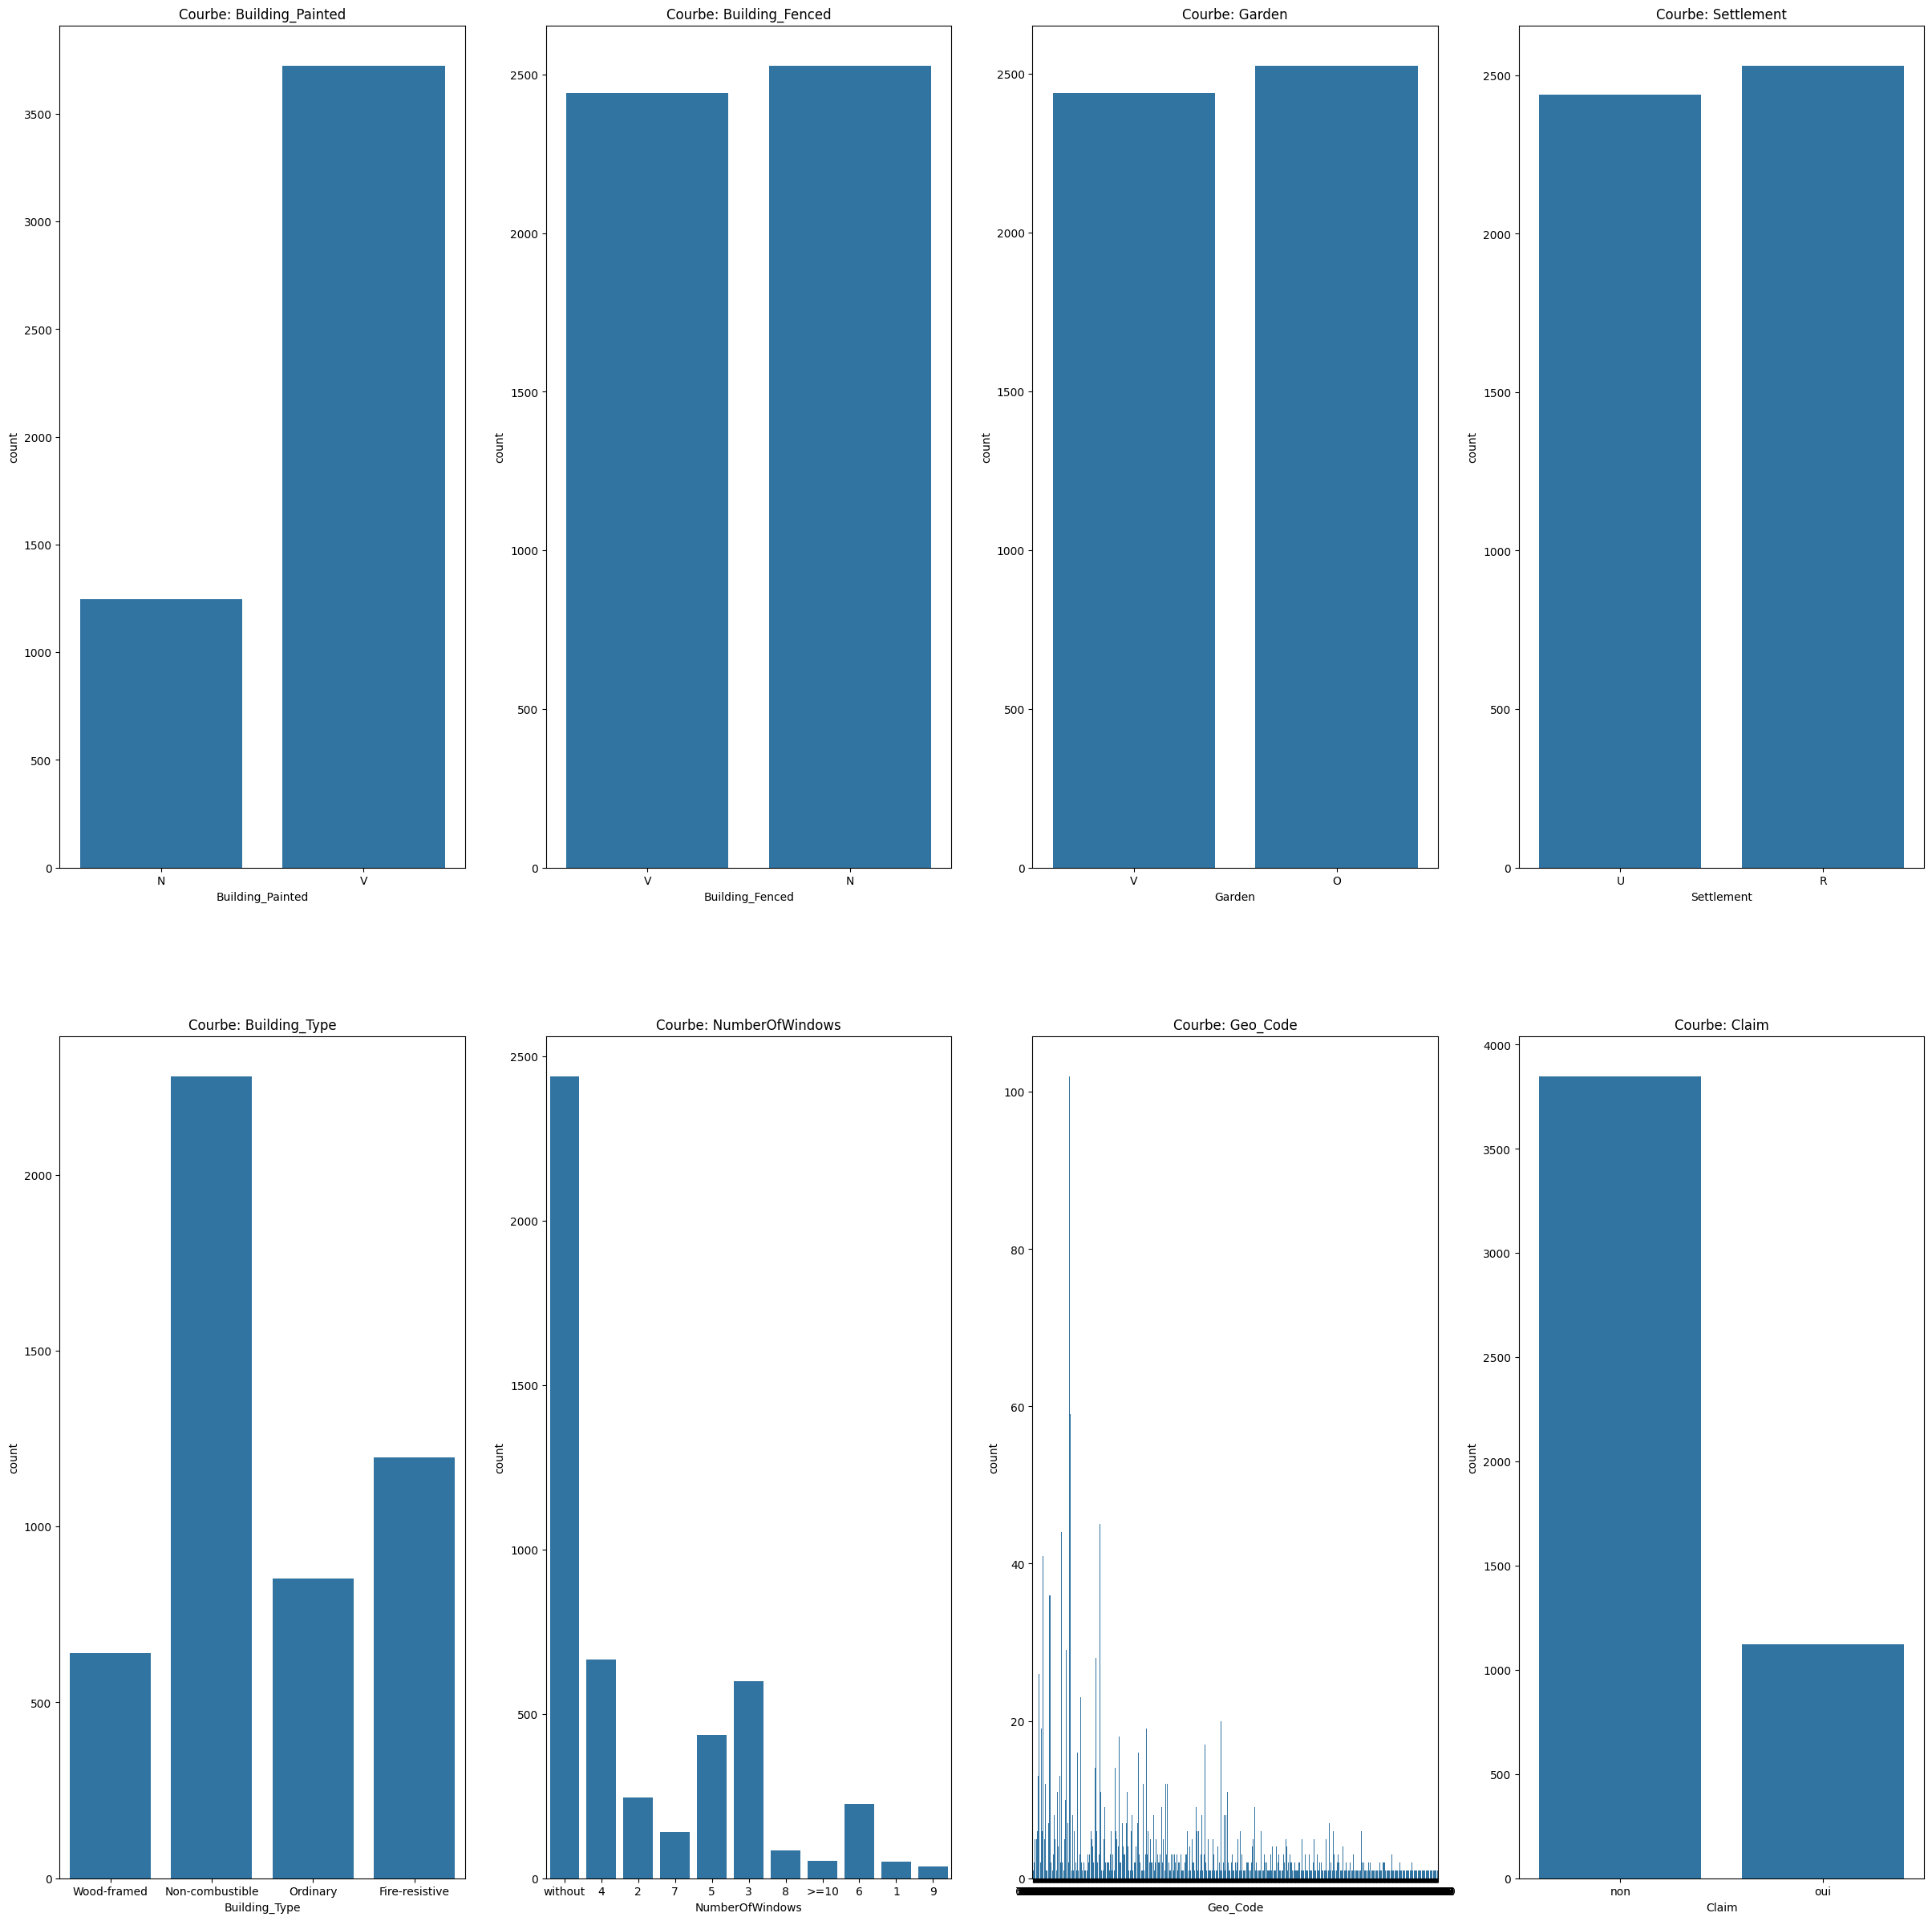

In [125]:
# Plot categorical variables distribution
plt.figure(figsize=(30, 30))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    sns.countplot(x=l_discret[i], data=df_insurance)
    plt.title("Courbe: " + l_discret[i])

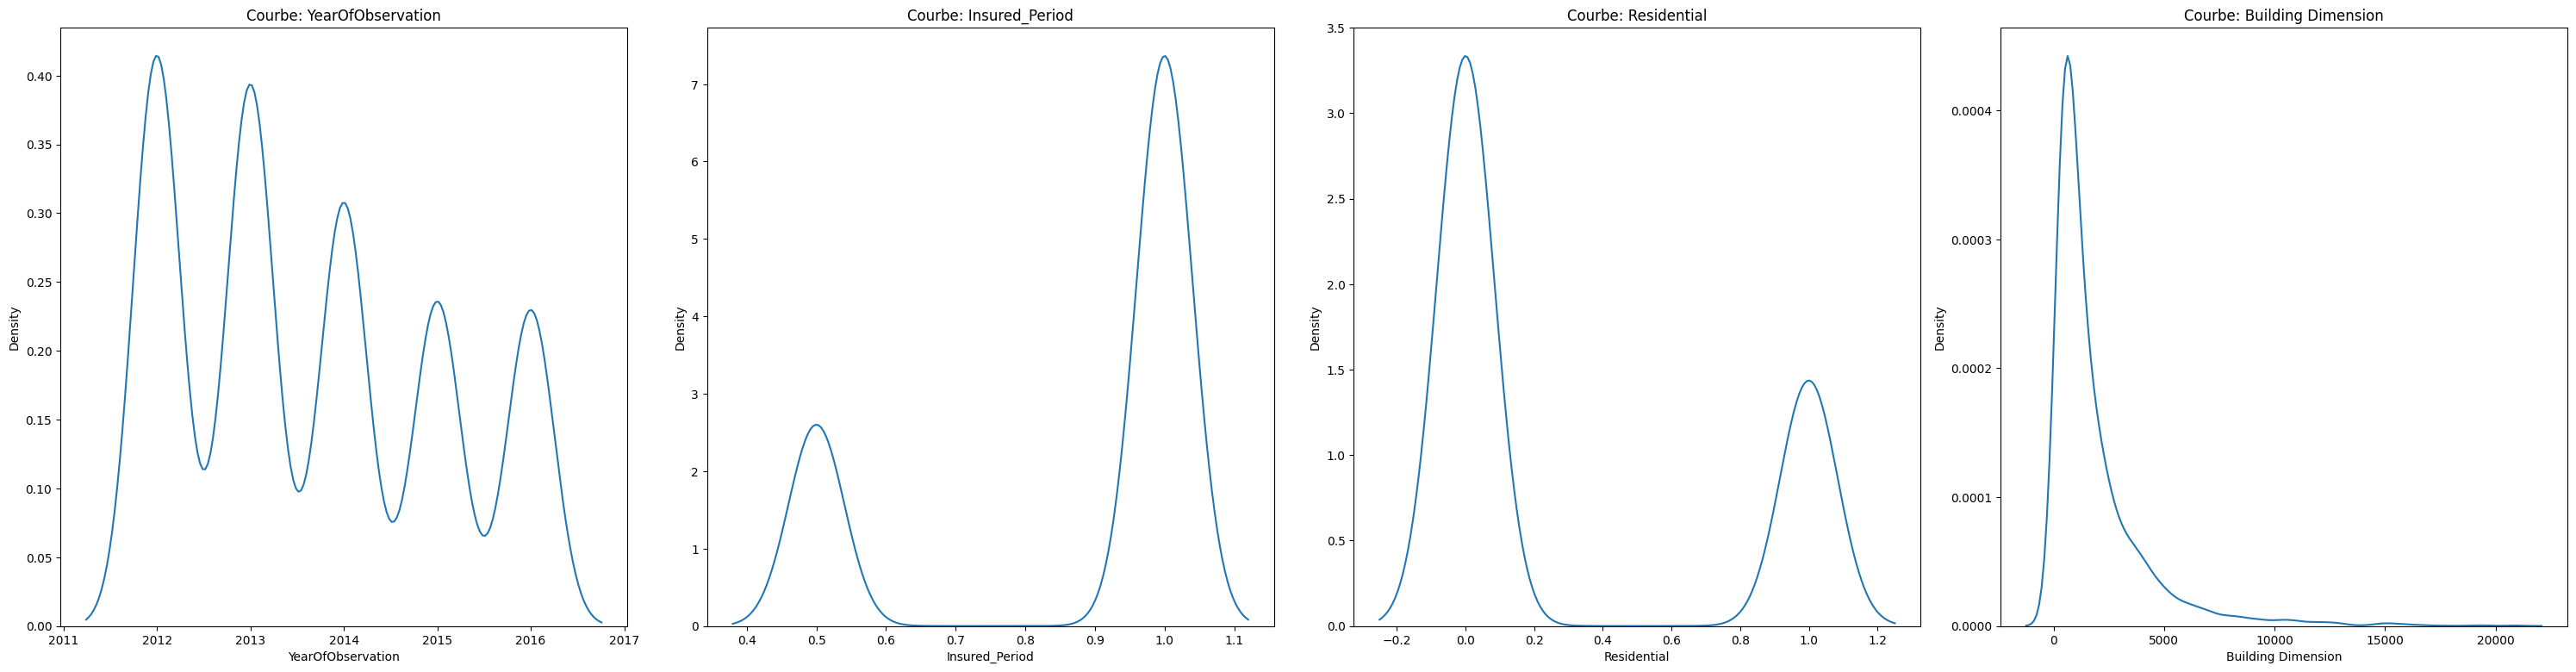

In [126]:
# Visualize continuous variables distribution
plt.figure(figsize=(30, 15))
for i, element in enumerate(l_continu):
    plt.subplot(2, 4, i + 1)  # Adjust subgraph grid as needed
    sns.kdeplot(df_insurance[element], bw_method='scott', bw_adjust=1)
    plt.title(f"Courbe: {element}")

plt.tight_layout()
plt.show()

# Depending on the distribution nature (right-skewed, left-skewed, symmetric),
# we'll apply the most suitable preprocessing techniques

In [127]:
# Dropping 'YearOfObservation' as it is just an indication of the observation year and has no influence on our prediction
df_insurance.drop(['YearOfObservation'], axis=1, inplace=True)

In [128]:
ord_categories= [["non","oui"]]
enc = OrdinalEncoder(categories=ord_categories) # Define the order of categories for encoding

df_insurance[['Claim']] = enc.fit_transform(df_insurance.loc[:, ['Claim']]) # Fit and transform the 'Claim' column

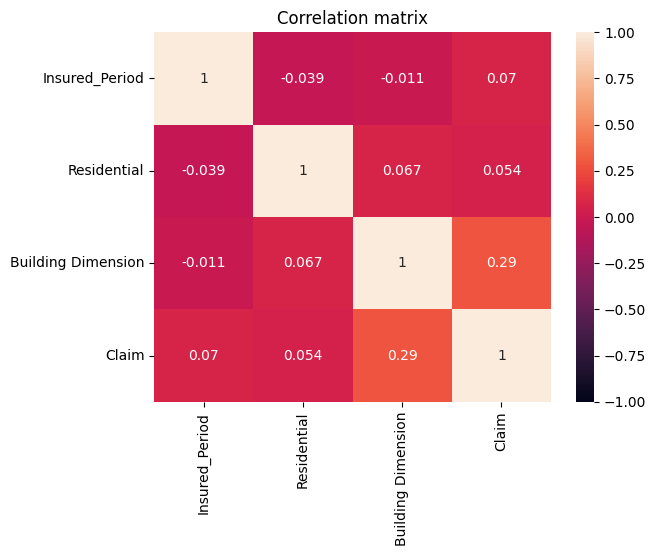

In [129]:
#Plot correlation matrix to visualize correlations between numerical attributes (up to now), especially with 'Claim'
df_corr = df_insurance.corr(numeric_only=True)
sns.heatmap(df_corr, annot=True, vmin=-1, vmax=1)
plt.title('Correlation matrix')
plt.show()

# Data cleaning

1) Missing values

In [130]:
df_insurance[df_insurance['Garden'].isna()]

,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Geo_Code,Claim
2321,1.0,0,V,N,NaN,R,6203.0,Fire-resistive,5,74173,0.0
3715,1.0,0,V,N,NaN,R,760.0,Fire-resistive,4,73015,0.0
4023,1.0,0,V,N,NaN,R,350.0,Fire-resistive,3,74173,0.0
4649,1.0,0,V,N,NaN,R,3900.0,Fire-resistive,5,61483,1.0


In [131]:
# Choice 1
from sklearn.impute import SimpleImputer
mf_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df_insurance[['Garden']] =mf_imputer.fit_transform(df_insurance.loc[:,['Garden']])

In [132]:
# Choice 2
# The majority of individuals with NaN values in "Garden" (3/4) belong to the "no" class, which is the majority class.
# Given their low proportion (0.00079%), they can be safely dropped.

#df_insurance.dropna(subset=['Garden'], inplace=True)
#df_insurance.reset_index(drop=True, inplace=True)

In [133]:
df_insurance.isna().sum() # Check if there are any missing values after imputation of "Garden"

Insured_Period         0
Residential            0
Building_Painted       0
Building_Fenced        0
Garden                 0
Settlement             0
Building Dimension    45
Building_Type          0
NumberOfWindows        0
Geo_Code              41
Claim                  0
dtype: int64

In [134]:
from sklearn.impute import KNNImputer

# Buildings within the same geographical zone (identified by Geo_code) share similar structure in terms of dimensions.
imputer = KNNImputer(n_neighbors=5)
df_insurance['Building Dimension'] = imputer.fit_transform(df_insurance[['Building Dimension']])
df_insurance.head()

,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Geo_Code,Claim
0,1.0,1,N,V,V,U,1240.0,Wood-framed,without,75117,0.0
1,1.0,0,N,V,V,U,900.0,Non-combustible,without,62916,0.0
2,1.0,1,V,N,O,R,4984.0,Non-combustible,4,31149,1.0
3,0.5,0,N,V,V,U,600.0,Wood-framed,without,6012,1.0
4,1.0,0,N,V,V,U,900.0,Non-combustible,without,57631,0.0


In [135]:
df_insurance.drop(['Geo_Code'], axis=1, inplace=True)

In [136]:
df_insurance.isna().sum() # Check

Insured_Period        0
Residential           0
Building_Painted      0
Building_Fenced       0
Garden                0
Settlement            0
Building Dimension    0
Building_Type         0
NumberOfWindows       0
Claim                 0
dtype: int64

2) Outliers

In [137]:
Q1,Q3=np.percentile(df_insurance["Building Dimension"], [25,75])
IQR=Q3-Q1
upper_limit=Q3+1.5*IQR
print(upper_limit)

4874.375


In [138]:
len(df_insurance[df_insurance['Building Dimension'] > upper_limit]) # 7.92% of data: Weighted average percentage that can influence model performance

392

In [139]:
# POV: These are extreme values and not outliers
# Buildings with dimensions greater than 4874.375 may exist in reality, however, those considered acceptable here do not exist in real life => 1m².
from sklearn.preprocessing import RobustScaler
standard_scaler= RobustScaler()
df_insurance['Building Dimension']= standard_scaler.fit_transform(df_insurance.loc[:,['Building Dimension']])

<Axes: >

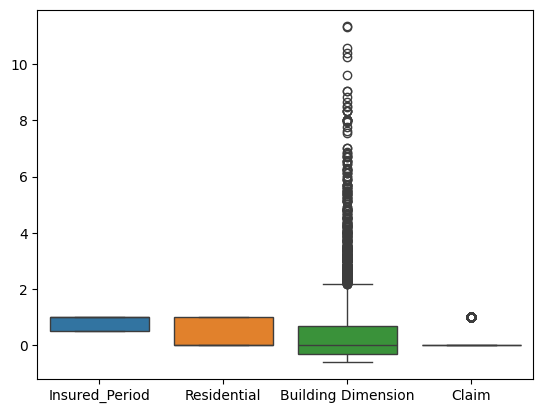

In [140]:
sns.boxplot(data=df_insurance)

# Data Transformation

In [141]:
df_insurance['Claim'].value_counts() # Imbalance data problem

Claim
0.0    3849
1.0    1121
Name: count, dtype: int64

In [142]:
# Before converting categorical data into numerical, we apply SMOTENC to balance the classes of "oui" and "non" due to the sensitivity of some algorithms to this imbalance.
# SMOTENC is specifically used when our dataset contains categorical variables. Even though we plan to transform them into numerical data later, applying SMOTE in this
# case is not recommended.

In [143]:
#x_train = df_insurance.drop('Claim', axis=1)
#y_train = df_insurance['Claim']

#desired_samples = sum(y_train == 0.0)
#categorical_features = list(df_insurance.select_dtypes(include="object"))
#categorical_indices = [index for index, column in enumerate(x_train.columns) if column in categorical_features]

#smote_nc = SMOTENC(categorical_features=categorical_indices, sampling_strategy={1.0: desired_samples}, k_neighbors=5)
#X_train_resampled, y_train_resampled = smote_nc.fit_resample(x_train, y_train)

In [144]:
#df_insurance = pd.concat([X_train_resampled, y_train_resampled], axis = 1)
df_insurance

,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Claim
0,1.0,1,N,V,V,U,0.080564,Wood-framed,without,0.0
1,1.0,0,N,V,V,U,-0.115091,Non-combustible,without,0.0
2,1.0,1,V,N,O,R,2.235074,Non-combustible,4,1.0
3,0.5,0,N,V,V,U,-0.287728,Wood-framed,without,1.0
4,1.0,0,N,V,V,U,-0.115091,Non-combustible,without,0.0
...,...,...,...,...,...,...,...,...,...,...
4965,1.0,0,N,V,V,U,-0.316501,Ordinary,without,1.0
4966,0.5,0,V,N,O,R,-0.057546,Fire-resistive,4,0.0
4967,1.0,1,V,N,O,R,-0.356783,Ordinary,3,0.0
4968,0.5,0,V,N,O,R,-0.324558,Fire-resistive,4,0.0


In [145]:
from sklearn.preprocessing import OrdinalEncoder

ord_categories= [['V','N'],['V','N'],['O', 'V'],['U', 'R'], ['Fire-resistive', 'Non-combustible','Ordinary', 'Wood-framed']]
enc = OrdinalEncoder(categories=ord_categories)

df_insurance[['Building_Painted', 'Building_Fenced', 'Garden', 'Settlement', 'Building_Type']] = enc.fit_transform(df_insurance.loc[:, ['Building_Painted', 'Building_Fenced', 'Garden', 'Settlement', 'Building_Type']])

<Axes: xlabel='NumberOfWindows', ylabel='count'>

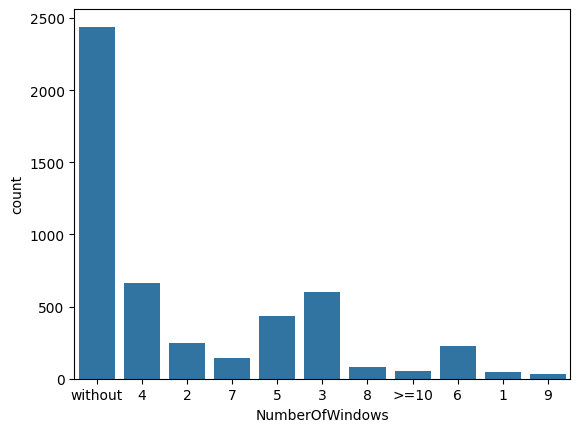

In [146]:
# Visualize the distribution of "NumberOfWindows"
sns.countplot(x='NumberOfWindows', data=df_insurance)

In [147]:
# Replace "without" with 0 and ">=10" with 10 in the 'NumberOfWindows' column
df_insurance['NumberOfWindows'] = np.where(df_insurance['NumberOfWindows'] == "without", 0, np.where(df_insurance['NumberOfWindows'] == ">=10", 10,df_insurance['NumberOfWindows']))

<Axes: xlabel='NumberOfWindows', ylabel='count'>

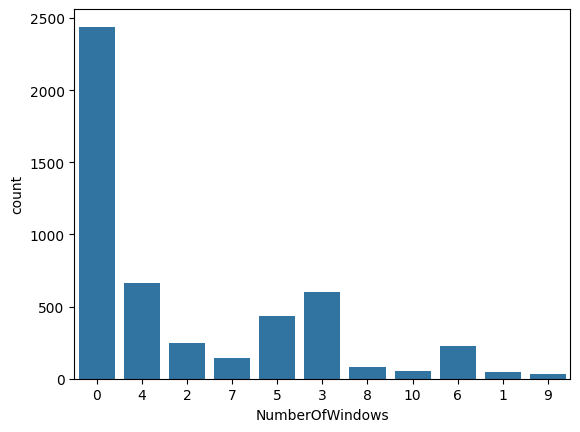

In [148]:
sns.countplot(x='NumberOfWindows', data=df_insurance)

In [149]:
df_insurance['NumberOfWindows'] = df_insurance['NumberOfWindows'].astype('int64')

<Axes: xlabel='NumberOfWindows', ylabel='Density'>

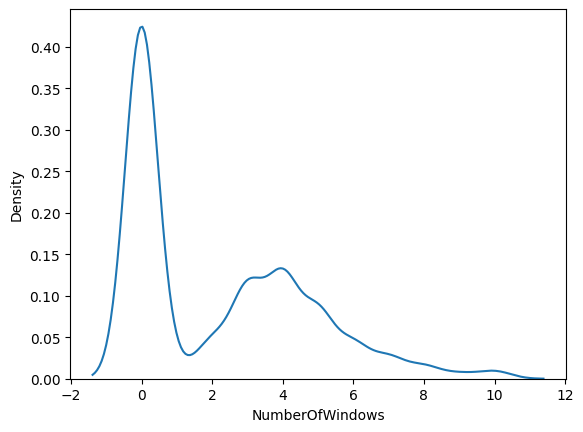

In [150]:
sns.kdeplot(df_insurance['NumberOfWindows'],bw_method='scott',bw_adjust=1)

In [151]:
# Alternative verification method
# Right asymmetrical distribution

print(df_insurance['NumberOfWindows'].mean())
print(df_insurance['NumberOfWindows'].median())

from scipy.stats import gaussian_kde
kde = gaussian_kde(df_insurance['NumberOfWindows'])
df_insurance.sort_values(by="NumberOfWindows", inplace=True)
x_vals = df_insurance["NumberOfWindows"].values
y_vals = kde(x_vals)
valeur_mode = x_vals[np.argmax(y_vals)]
print(valeur_mode)
# mode < median < mean : distribution right-skewed => Equal-Frequency Discretization «quantile»

2.2167002012072436
1.0
0


# Data discretization

In [152]:
from sklearn.preprocessing import KBinsDiscretizer
enc = KBinsDiscretizer(n_bins=4, encode='ordinal',strategy='quantile', subsample=len(df_insurance))
df_insurance['NumberOfWindows'] = enc.fit_transform(df_insurance[['NumberOfWindows']])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [153]:
df_insurance.reset_index(drop=True, inplace=True)

In [154]:
df_insurance['NumberOfWindows']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4965    2.0
4966    2.0
4967    2.0
4968    2.0
4969    2.0
Name: NumberOfWindows, Length: 4970, dtype: float64

<Axes: xlabel='NumberOfWindows', ylabel='Density'>

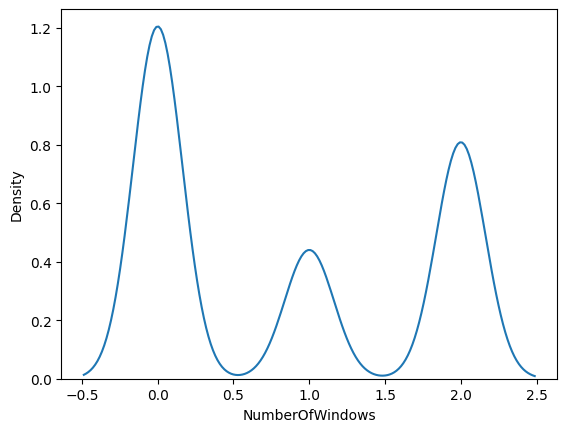

In [155]:
sns.kdeplot(df_insurance['NumberOfWindows'],bw_method='scott',bw_adjust=1)

In [156]:
df_insurance

,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Claim
0,1.0,1,1.0,0.0,1.0,0.0,0.080564,3.0,0.0,0.0
1,1.0,1,1.0,0.0,1.0,0.0,-0.258380,0.0,0.0,0.0
2,0.5,0,0.0,0.0,1.0,0.0,0.204287,1.0,0.0,0.0
3,1.0,0,0.0,0.0,1.0,0.0,-0.235937,0.0,0.0,0.0
4,0.5,0,1.0,0.0,1.0,0.0,-0.448856,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4965,1.0,0,0.0,1.0,0.0,1.0,3.151201,1.0,2.0,1.0
4966,1.0,0,0.0,1.0,0.0,1.0,4.085743,1.0,2.0,1.0
4967,1.0,1,0.0,1.0,0.0,1.0,8.493742,2.0,2.0,1.0
4968,1.0,1,0.0,1.0,0.0,1.0,1.421378,2.0,2.0,1.0


# Dimensionality Reduction

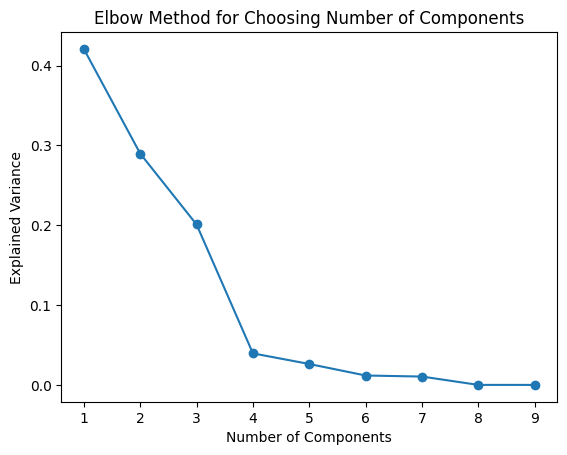

In [157]:
X = df_insurance.drop('Claim', axis=1)
pca = PCA()

X_pca = pca.fit_transform(X)

explained_variance = pca.explained_variance_ratio_
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Elbow Method for Choosing Number of Components')
plt.show()

Explained variance ratio for each component: [0.42096714 0.28988747 0.20101332]


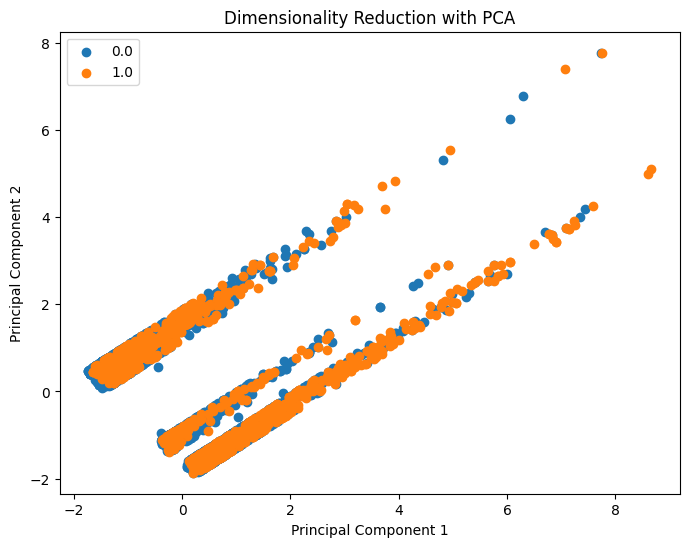

                       Insured_Period  Residential  Building_Painted  \
Principal Component 1       -0.002867     0.041885         -0.129499   
Principal Component 2        0.001395    -0.026302          0.170805   
Principal Component 3        0.000433     0.192902          0.059503   

                       Building_Fenced    Garden  Settlement  \
Principal Component 1         0.234559 -0.234609    0.234562   
Principal Component 2        -0.315979  0.316118   -0.316033   
Principal Component 3        -0.046679  0.046749   -0.046752   

                       Building Dimension  Building_Type  NumberOfWindows  
Principal Component 1            0.780885       0.041074         0.452681  
Principal Component 2            0.623259      -0.075579        -0.525659  
Principal Component 3            0.010167       0.975409        -0.034225  


In [158]:
X = df_insurance.drop('Claim', axis=1)
y = df_insurance['Claim']

pca = PCA(n_components=3)

X_pca = pca.fit_transform(X)

print("Explained variance ratio for each component:", pca.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
for i, target_name in enumerate(list(df_insurance['Claim'].value_counts().index)):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], label=target_name)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Dimensionality Reduction with PCA')
plt.legend()
plt.show()

components = pca.components_

components_df = pd.DataFrame(components, columns=list(df_insurance.iloc[:, :-1].columns), index=[f'Principal Component {i+1}' for i in range(pca.n_components_)])

print(components_df)


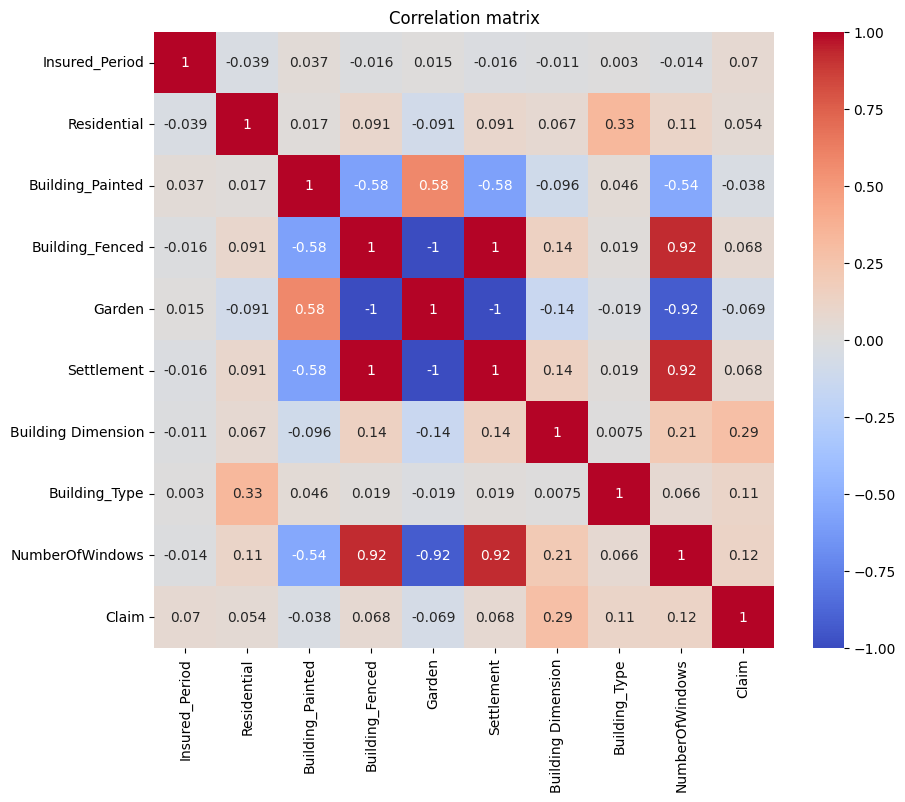

In [159]:
df_corr = df_insurance.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True, vmin=-1, vmax=1, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

In [160]:
df_corr['Claim'].sort_values()

Garden               -0.068710
Building_Painted     -0.037809
Residential           0.054127
Building_Fenced       0.067964
Settlement            0.068493
Insured_Period        0.069657
Building_Type         0.114088
NumberOfWindows       0.117686
Building Dimension    0.286744
Claim                 1.000000
Name: Claim, dtype: float64

In [161]:
# At this point, we could eliminate columns with a weak correlation to the target variable "Claim" (correlation ≤ 0.1).
# However, I choose to retain all columns as performance did not significantly improve with elimination.

#df_insurance = df_insurance.loc[:,['Insured_Period','Building Dimension','Building_Type','NumberOfWindows','Claim']]

In [162]:
df_insurance

,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Claim
0,1.0,1,1.0,0.0,1.0,0.0,0.080564,3.0,0.0,0.0
1,1.0,1,1.0,0.0,1.0,0.0,-0.258380,0.0,0.0,0.0
2,0.5,0,0.0,0.0,1.0,0.0,0.204287,1.0,0.0,0.0
3,1.0,0,0.0,0.0,1.0,0.0,-0.235937,0.0,0.0,0.0
4,0.5,0,1.0,0.0,1.0,0.0,-0.448856,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4965,1.0,0,0.0,1.0,0.0,1.0,3.151201,1.0,2.0,1.0
4966,1.0,0,0.0,1.0,0.0,1.0,4.085743,1.0,2.0,1.0
4967,1.0,1,0.0,1.0,0.0,1.0,8.493742,2.0,2.0,1.0
4968,1.0,1,0.0,1.0,0.0,1.0,1.421378,2.0,2.0,1.0


# Classification Model and Performance Evaluation


In [163]:
x_train = df_insurance.drop('Claim', axis=1)
y_train = df_insurance['Claim']

print(x_train.shape); print(y_train.shape);

(4970, 9)
(4970,)


In [164]:
df_test = pd.read_csv('/content/drive/MyDrive/ML project/test_Insurance_clean.csv', sep=',') # Load the test dataset
df_test

,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Claim
0,1.0,0,0.0,0.0,1.0,0.0,1.520770,0.0,0.0,1.0
1,1.0,0,0.0,0.0,1.0,0.0,1.129797,1.0,0.0,1.0
2,1.0,0,1.0,0.0,1.0,0.0,-0.051171,3.0,0.0,0.0
3,0.5,0,1.0,0.0,1.0,0.0,0.152365,1.0,0.0,0.0
4,1.0,0,0.0,0.0,1.0,0.0,-0.399598,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2137,1.0,1,0.0,1.0,0.0,1.0,2.035935,3.0,2.0,0.0
2138,1.0,1,0.0,1.0,0.0,1.0,1.411528,2.0,2.0,0.0
2139,1.0,0,0.0,1.0,0.0,1.0,1.946241,0.0,2.0,0.0
2140,1.0,1,0.0,1.0,0.0,1.0,5.502947,1.0,2.0,0.0


In [165]:
x_test = df_test.drop('Claim', axis=1)
y_test = df_test['Claim']

In [166]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train) # If we opt not to use SMOTENC, we must consider the imbalance in the data.

To improve the performance of my classifiers, I used the most recommended hyperparameters.

However, to obtain the most suitable hyperparameters for this case and have better performance, we must use GridSearchCV or RandomizedSearchCV.

Decision Tree Classifier

In [167]:
cls1 = DecisionTreeClassifier(max_depth=5, min_samples_split=10, min_samples_leaf=5, class_weight=dict(enumerate(class_weights)))
cls1.fit(x_train,y_train)
cls1.classes_

array([0., 1.])

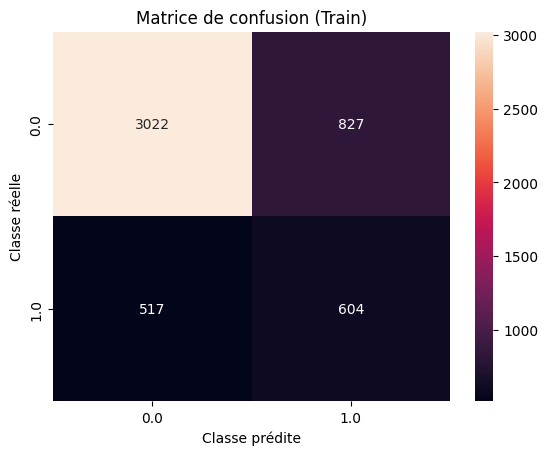

In [168]:
# Training Data Validation
y_p_train = cls1.predict(x_train)
c_m_train = confusion_matrix(y_train, y_p_train)

sns.heatmap(c_m_train, annot=True, cbar=True, xticklabels=cls1.classes_, yticklabels=cls1.classes_, fmt='d')
plt.title('Confusion Matrix (Train)')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

In [169]:
print("Accuracy: {:.3f}".format(accuracy_score(y_train,y_p_train)))
print("Weighted Average Recall: {:.3f}".format(recall_score(y_train,y_p_train, average='weighted')))
print("Weighted Average Precision: {:.3f}".format(precision_score(y_train,y_p_train, average='weighted')))
print("Weighted Average F1-Score: {:.3f}".format(f1_score(y_train,y_p_train, average='weighted')))

Accuracy: 0.730
Weighted Average Recall: 0.730
Weighted Average Precision: 0.757
Weighted Average F1-Score: 0.740


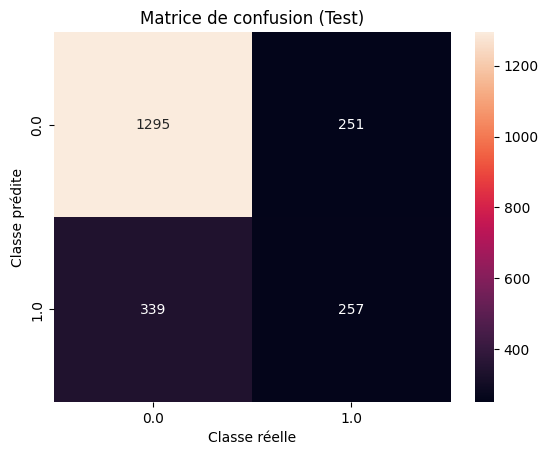

In [170]:
# Validation on Test Data
y_p_test = cls1.predict(x_test)
c_m_test = confusion_matrix(y_p_test, y_test)

sns.heatmap(c_m_test, annot=True, cbar=True, xticklabels=cls1.classes_, yticklabels=cls1.classes_, fmt='d')
plt.title('Confusion Matrix (Test)')
plt.xlabel('Actual Class')
plt.ylabel('Predicted Class')
plt.show()

In [171]:
print("Accuracy: {:.3f}".format(accuracy_score(y_test,y_p_test)))
print("Weighted Average Recall: {:.3f}".format(recall_score(y_test,y_p_test, average='weighted')))
print("Weighted Average Precision: {:.3f}".format(precision_score(y_test,y_p_test, average='weighted')))
print("Weighted Average F1-Score: {:.3f}".format(f1_score(y_test,y_p_test, average='weighted')))

Accuracy: 0.725
Weighted Average Recall: 0.725
Weighted Average Precision: 0.741
Weighted Average F1-Score: 0.732


Random Forest Classifier

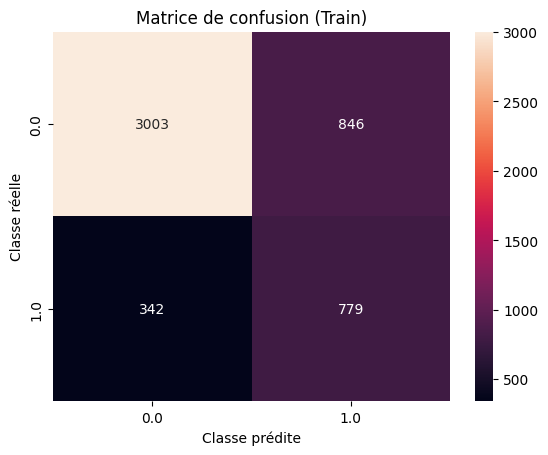

In [172]:
cls2 = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=5, max_features='sqrt', class_weight=dict(enumerate(class_weights)), random_state=42)
cls2.fit(x_train, y_train)

y_p_train=cls2.predict(x_train)
c_m_train=confusion_matrix(y_train, y_p_train)

sns.heatmap(c_m_train, annot=True, cbar=True, xticklabels=cls2.classes_, yticklabels=cls2.classes_, fmt='d')
plt.title('Confusion Matrix (Train)')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

In [173]:
print("Accuracy: {:.3f}".format(accuracy_score(y_train,y_p_train)))
print("Weighted Average Recall: {:.3f}".format(recall_score(y_train,y_p_train, average='weighted')))
print("Weighted Average Precision: {:.3f}".format(precision_score(y_train,y_p_train, average='weighted')))
print("Weighted Average F1-Score: {:.3f}".format(f1_score(y_train,y_p_train, average='weighted')))

Accuracy: 0.761
Weighted Average Recall: 0.761
Weighted Average Precision: 0.803
Weighted Average F1-Score: 0.775


In [174]:
importances = cls2.feature_importances_

feature_importances = pd.DataFrame({'Feature': x_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False, ignore_index=True)

print(feature_importances)
print(cls2.classes_)

              Feature  Importance
0  Building Dimension    0.728736
1       Building_Type    0.095868
2     NumberOfWindows    0.067411
3      Insured_Period    0.041787
4         Residential    0.029123
5    Building_Painted    0.017371
6              Garden    0.007113
7     Building_Fenced    0.006775
8          Settlement    0.005817
[0. 1.]


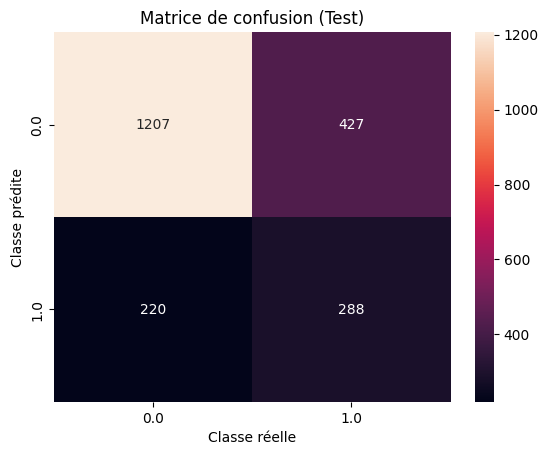

In [175]:
y_p_test=cls2.predict(x_test)
c_m_test=confusion_matrix(y_test, y_p_test)

sns.heatmap(c_m_test, annot=True, cbar=True, xticklabels=cls2.classes_, yticklabels=cls2.classes_, fmt='d')
plt.title('Confusion Matrix (Test)')
plt.xlabel('Actual Class')
plt.ylabel('Predicted Class')
plt.show()

In [176]:
print("Accuracy: {:.3f}".format(accuracy_score(y_test,y_p_test)))
print("Weighted Average Recall: {:.3f}".format(recall_score(y_test,y_p_test, average='weighted')))
print("Weighted Average Precision: {:.3f}".format(precision_score(y_test,y_p_test, average='weighted')))
print("Weighted Average F1-Score: {:.3f}".format(f1_score(y_test,y_p_test, average='weighted')))

Accuracy: 0.698
Weighted Average Recall: 0.698
Weighted Average Precision: 0.741
Weighted Average F1-Score: 0.713


Logistic Regression

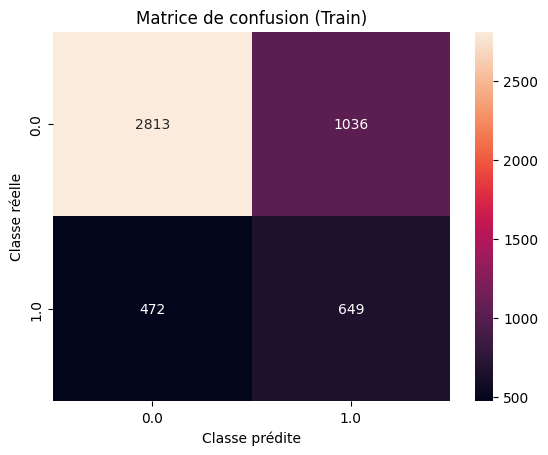

In [177]:
cls3 = LogisticRegression(class_weight=dict(enumerate(class_weights)))

cls3.fit(x_train, y_train)

y_p_train=cls3.predict(x_train)
c_m_train=confusion_matrix(y_train, y_p_train)

sns.heatmap(c_m_train, annot=True, cbar=True, xticklabels=cls3.classes_, yticklabels=cls3.classes_, fmt='d')
plt.title('Confusion Matrix (Train)')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

In [178]:
print("Accuracy: {:.3f}".format(accuracy_score(y_train,y_p_train)))
print("Weighted Average Recall: {:.3f}".format(recall_score(y_train,y_p_train, average='weighted')))
print("Weighted Average Precision: {:.3f}".format(precision_score(y_train,y_p_train, average='weighted')))
print("Weighted Average F1-Score: {:.3f}".format(f1_score(y_train,y_p_train, average='weighted')))

Accuracy: 0.697
Weighted Average Recall: 0.697
Weighted Average Precision: 0.750
Weighted Average F1-Score: 0.715


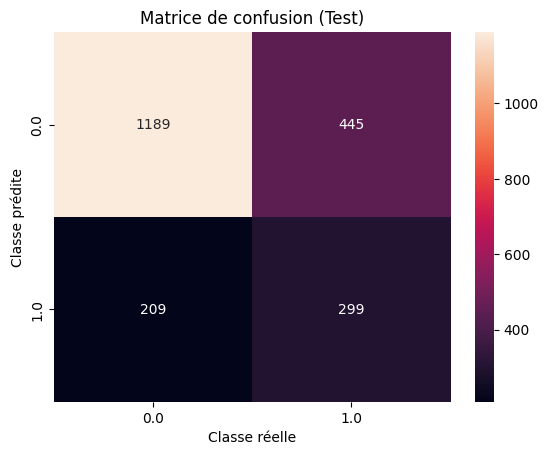

In [179]:
y_p_test=cls3.predict(x_test)
c_m_test=confusion_matrix(y_test, y_p_test)

sns.heatmap(c_m_test, annot=True, cbar=True, xticklabels=cls3.classes_, yticklabels=cls3.classes_, fmt='d')
plt.title('Confusion Matrix (Test)')
plt.xlabel('Actual Class')
plt.ylabel('Predicted Class')
plt.show()

In [180]:
print("Accuracy: {:.3f}".format(accuracy_score(y_test,y_p_test)))
print("Weighted Average Recall: {:.3f}".format(recall_score(y_test,y_p_test, average='weighted')))
print("Weighted Average Precision: {:.3f}".format(precision_score(y_test,y_p_test, average='weighted')))
print("Weighted Average F1-Score: {:.3f}".format(f1_score(y_test,y_p_test, average='weighted')))

Accuracy: 0.695
Weighted Average Recall: 0.695
Weighted Average Precision: 0.744
Weighted Average F1-Score: 0.712


SVC

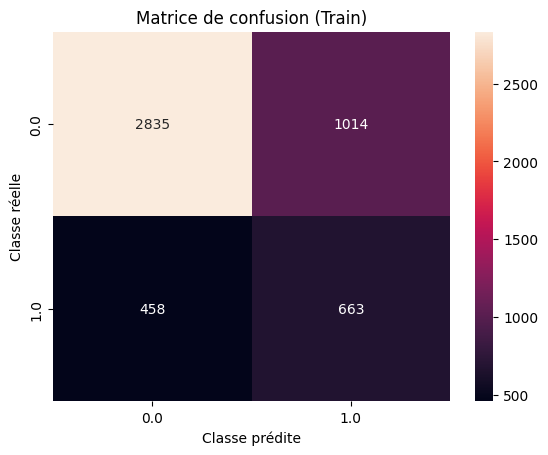

In [181]:
cls4 = SVC(class_weight=dict(enumerate(class_weights)))
cls4.fit(x_train, y_train)
# Validation sur les données d'entrainement
y_p_train = cls4.predict(x_train)
c_m_train = confusion_matrix(y_train, y_p_train)

sns.heatmap(c_m_train, annot=True, cbar=True, xticklabels=cls4.classes_, yticklabels=cls4.classes_, fmt='d')
plt.title('Confusion Matrix (Train)')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

In [182]:
print("Accuracy: {:.3f}".format(accuracy_score(y_train,y_p_train)))
print("Weighted Average Recall: {:.3f}".format(recall_score(y_train,y_p_train, average='weighted')))
print("Weighted Average Precision: {:.3f}".format(precision_score(y_train,y_p_train, average='weighted')))
print("Weighted Average F1-Score: {:.3f}".format(f1_score(y_train,y_p_train, average='weighted')))

Accuracy: 0.704
Weighted Average Recall: 0.704
Weighted Average Precision: 0.756
Weighted Average F1-Score: 0.722


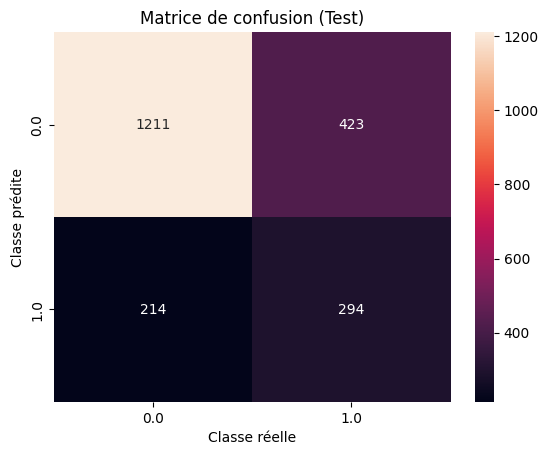

In [183]:
y_p_test=cls4.predict(x_test)
c_m_test=confusion_matrix(y_test, y_p_test)

sns.heatmap(c_m_test, annot=True, cbar=True, xticklabels=cls4.classes_, yticklabels=cls4.classes_, fmt='d')
plt.title('Confusion Matrix (Test)')
plt.xlabel('Actual Class')
plt.ylabel('Predicted Class')
plt.show()

In [184]:
print("Accuracy: {:.3f}".format(accuracy_score(y_test,y_p_test)))
print("Weighted Average Recall: {:.3f}".format(recall_score(y_test,y_p_test, average='weighted')))
print("Weighted Average Precision: {:.3f}".format(precision_score(y_test,y_p_test, average='weighted')))
print("Weighted Average F1-Score: {:.3f}".format(f1_score(y_test,y_p_test, average='weighted')))

Accuracy: 0.703
Weighted Average Recall: 0.703
Weighted Average Precision: 0.746
Weighted Average F1-Score: 0.718


MLP Classifier

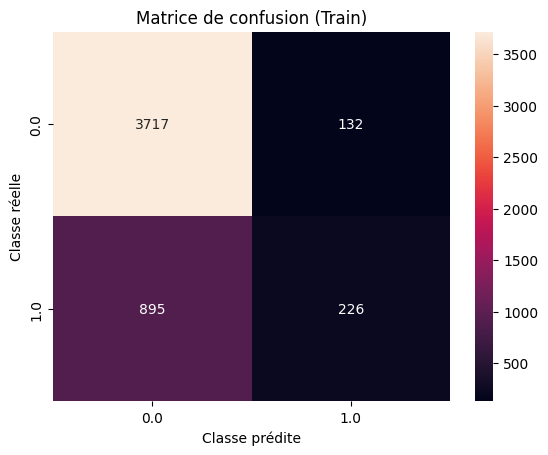

In [185]:
cls5 = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.0001, learning_rate='adaptive', max_iter=200, random_state=42)

cls5 = MLPClassifier()
cls5.fit(x_train, y_train)

y_p_train = cls5.predict(x_train)

c_m_train = confusion_matrix(y_train, y_p_train)
sns.heatmap(c_m_train, annot=True, cbar=True, xticklabels=cls5.classes_, yticklabels=cls5.classes_, fmt='d')
plt.title('Confusion Matrix (Train)')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

In [186]:
print("Accuracy: {:.3f}".format(accuracy_score(y_train,y_p_train)))
print("Weighted Average Recall: {:.3f}".format(recall_score(y_train,y_p_train, average='weighted')))
print("Weighted Average Precision: {:.3f}".format(precision_score(y_train,y_p_train, average='weighted')))
print("Weighted Average F1-Score: {:.3f}".format(f1_score(y_train,y_p_train, average='weighted')))

Accuracy: 0.793
Weighted Average Recall: 0.793
Weighted Average Precision: 0.767
Weighted Average F1-Score: 0.749


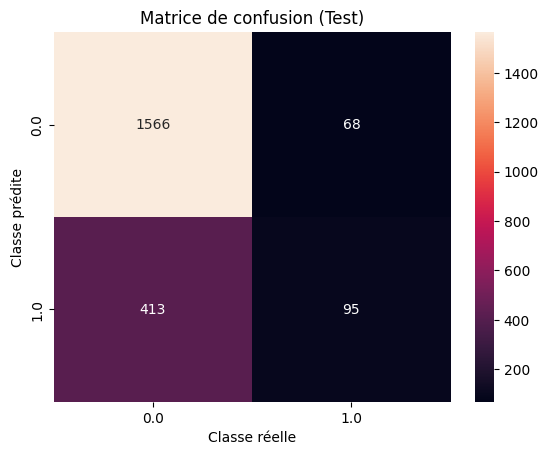

In [187]:
y_p_test=cls5.predict(x_test)
c_m_test=confusion_matrix(y_test, y_p_test)

sns.heatmap(c_m_test, annot=True, cbar=True, xticklabels=cls5.classes_, yticklabels=cls5.classes_, fmt='d')
plt.title('Confusion Matrix (Test)')
plt.xlabel('Actual Class')
plt.ylabel('Predicted Class')
plt.show()

In [188]:
print("Accuracy: {:.3f}".format(accuracy_score(y_test,y_p_test)))
print("Weighted Average Recall: {:.3f}".format(recall_score(y_test,y_p_test, average='weighted')))
print("Weighted Average Precision: {:.3f}".format(precision_score(y_test,y_p_test, average='weighted')))
print("Weighted Average F1-Score: {:.3f}".format(f1_score(y_test,y_p_test, average='weighted')))

Accuracy: 0.775
Weighted Average Recall: 0.775
Weighted Average Precision: 0.742
Weighted Average F1-Score: 0.728
